# Regression / XGBRegressor


In [1]:
import sys  
sys.path.insert(0, '../../codes/')

import xgboost as xgb
from xgboost import XGBRegressor

from predict_observational_dataset_v2 import ProcessObservationalDataset
from train_ml_regression_2 import *
from train_cnn_regression_3 import *
import io_funs


2023-05-31 14:41:59.747467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

# Step 1: data processing

This dataframe includes:
- `Targets`:
        1. gravity ,
        2. temperature ,
        3. c_o_ratio, 
        4. metallicity
- `Features`: 
        Brown dwarf fluxes for wavelengths 2.512 -- 0.897 micron

In [2]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(5)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
3,5.0,1100,0.25,-0.3,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
4,5.0,1100,0.25,0.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [3]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head()

,wl
0,2.511960
1,2.486966
2,2.462220
3,2.437720
4,2.413464


## Prepare feature variables (X) and targets (y)

In [4]:
# random = list(np.random.randint(0,len(df),10_000))

df = df[df['is_augmented'].isin(['no'])]#.iloc[random]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented']).astype(np.float64)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]].astype(np.float64)

skewness:


{('c_o_ratio', 0.1577441958491052),
 ('gravity', 0.0),
 ('metallicity', 0.16546438330218305),
 ('temperature', 0.7427625871851421)}

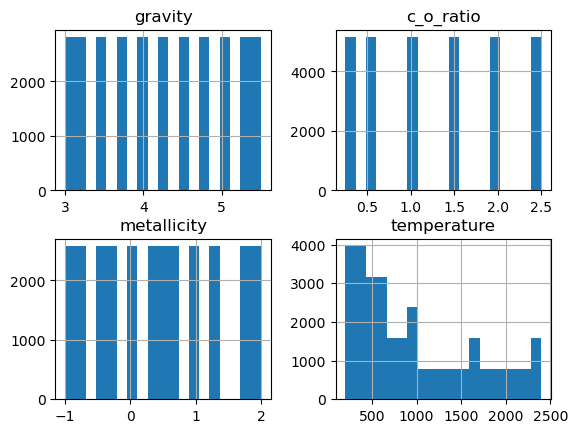

In [5]:
print( 'skewness:' )
display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
y.hist(grid=True, bins=19);

In [6]:
y['temperature'] = np.log10(y['temperature'])

skewness:


{('c_o_ratio', 0.1577441958491052),
 ('gravity', 0.0),
 ('metallicity', 0.16546438330218305),
 ('temperature', -0.04214190742902561)}

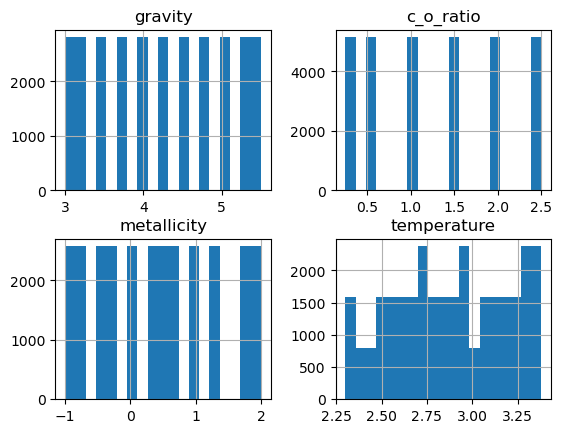

In [7]:
print( 'skewness:' )
display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
y.hist(grid=True, bins=19);

---

# Step 2: Train ML model


### Define XGBoost Hyperparameters for Tuning

In [8]:
# With including all features
# Link: https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook
# Link: https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html#child_weight


"""
Ref: https://www.capitalone.com/tech/machine-learning/how-to-control-your-xgboost-model/

---------------------------------------

+ General Parameters:

- booster [default=gbtree]
   Choosing which booster to use such as gbtree and dart for tree based models and gblinear for linear functions.


- n_estimators [default=100]: 
   This is the number of trees in our ensemble which is the same number of boosting rounds.
---------------------------------------
+ Pruning
Pruning removes splits directly from the trees during or after the build process (see more below):

- max_depth [default=6]:
   Increasing this value will make the model more complex and more likely to overfit, therefore you need to be careful when choosing your value.

- min_child_weight [default=1]
    min_child_weight is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

---------------------------------------
+ Regularization
The regularization parameters act directly on the weights:


- learning_rate (eta)eta [default=0.3, alias: learning_rate]:
   This determines the step size at each iteration. 
   The value must be between 0 and 1 and the default is 0.3. 

- lambda [default=1, alias: reg_lambda]
   L2 (Ridge Regression) regularization on weights. 
   When you increase this value it will make the model more conservative. 
   It can also be used to help to reduce overfitting. It can be any integer and the default is 1.
---------------------------------------
+ Sampling
   Sampling makes the boosted trees less correlated and prevents some feature masking effects. 
   This makes them less correlated and more robust to noise:

- subsample [default=1]
   This represents the fraction of observations/features that need to be sampled for each tree. 
   A lower value helps to prevent overfitting, but raises the possibility of under-fitting. 
   The value must be between 0 and 1, where the default is 1.

- colsample_bytree, colsample_bylevel, colsample_bynode [default=1]
   This is a family of parameters for subsampling of columns. 
   Feature subsampling helps to prevent overfitting and also speeds up computations of the parallel algorithm.
 
"""
param_grid= {    'learning_rate': Real(0.01, 0.8,  prior = "log-uniform"),
                 'max_depth'    : Integer(2, 8),
                 'subsample'    : Real(0.6, 1.0, prior = 'uniform'),
                 'colsample_bytree': Real(0.6, 1.0, prior = 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda'   : Real(1e-3, 10., prior = 'uniform'), # L2 or Ridge regularization
                 'n_estimators' : Integer(50, 2000),
                 'min_child_weight' : Real(0.9, 1.1, prior = 'uniform'),
    }


### Instentiate the TrainMlRegression to train the XGBoost model

In [9]:
xgb_model = TrainMlRegression (
                        feature_values = X.to_numpy(), # fulx values 
                        feature_names  = X.columns.values,
                        target_values  = y, 
                        target_name    = ['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                        is_tuned         = 'yes', # 'yes' if you want to tune the parameters
                        param_grid     = param_grid, # hyperparameters to tune, 
                        spectral_resolution = 100,
                        is_feature_improved = 'yes',
                        n_jobs = 10,  # number of processors to use
                        cv     = 5,   # Determines the cross-validation splitting strategy
                        is_augmented =  'no',  # select 'yes' if you are using augmented dataset 
                        ml_model     =   XGBRegressor(), 
                        ml_model_str =  'XGBRegressor',
            )

### Process the dataset

In [10]:
# split the brown dwarf dataset into train and test sets
xgb_model.split_train_validation_test(test_size=0.1, val_size=0.1)

### standardize_X_column_wise

In [11]:
# for tree-based models, we do not need to scale the X, check the y!!!!
xgb_model.standardize_X_column_wise()

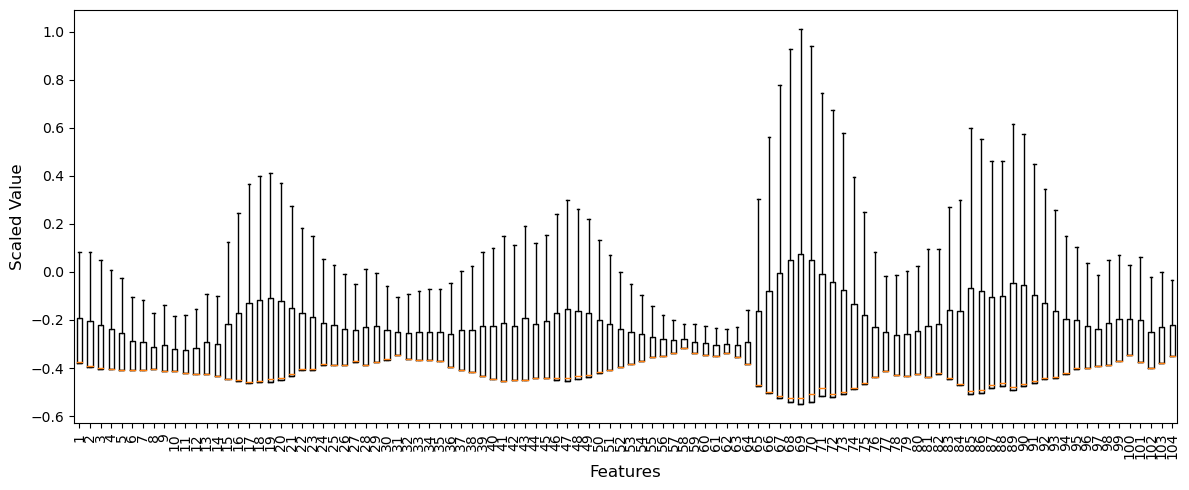

In [12]:
xgb_model.plot_boxplot_scaled_features(xgb_model.X_train_standardized_columnwise)

### standardize_y_column_wise

In [13]:
xgb_model.standardize_y_column_wise()

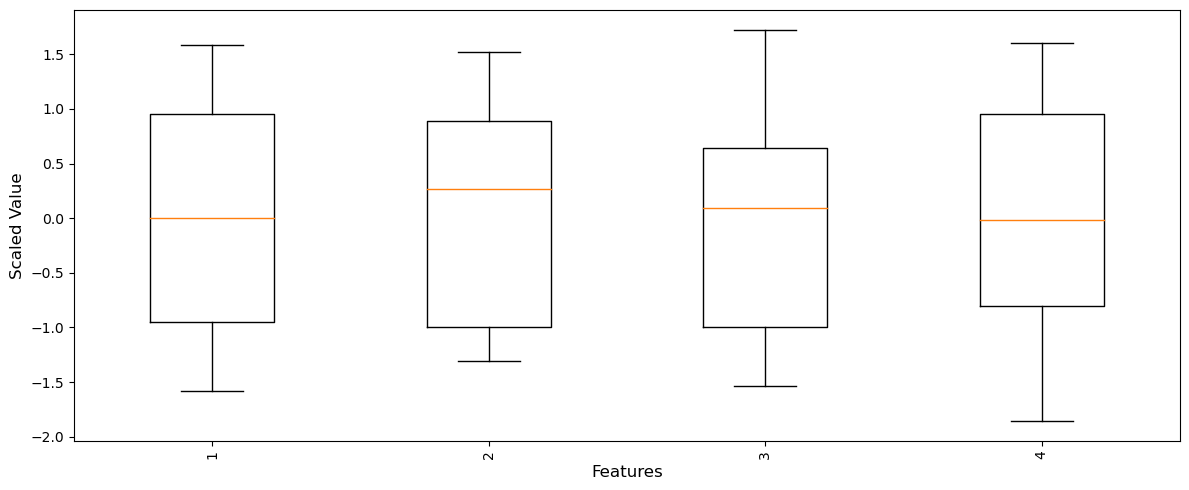

In [14]:
xgb_model.plot_boxplot_scaled_features(xgb_model.y_train_standardized_columnwise)

### Train the ML model

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
 ==============    Optimal HyperParameters    ============== 
total_iterations 28
val. score: 0.9140218272950152
test score: -21.66366101988814


"best params: OrderedDict([('colsample_bytree', 0.8811720468963327), ('learning_rate', 0.028920579465453143), ('max_depth', 5), ('min_child_weight', 1.0761517400816185), ('n_estimators', 1885), ('reg_lambda', 2.979689202330572), ('subsample', 0.8579674215945645)])"

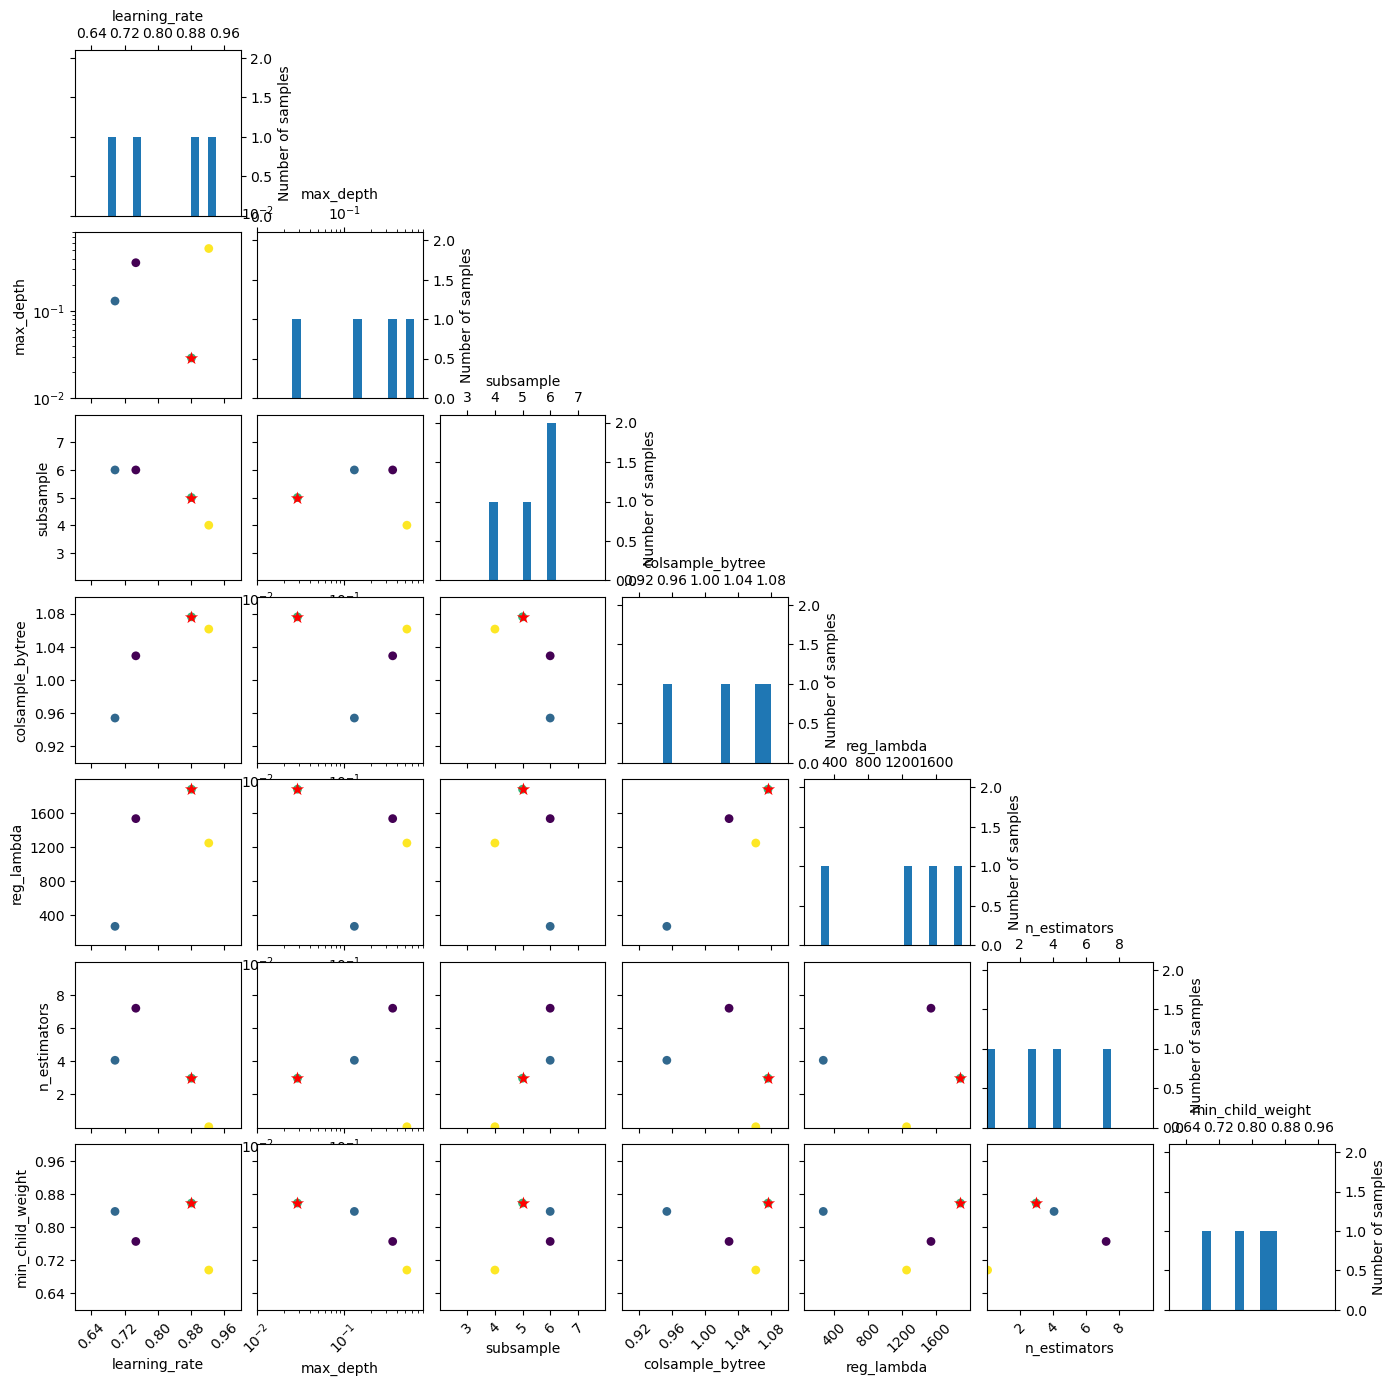

In [16]:
portion_index = 3
xgb_model.train_regression_model(X_train = xgb_model.X_train_standardized_columnwise[::portion_index],
                                 X_val   = xgb_model.X_val_standardized_columnwise[::portion_index],
                                 X_test  = xgb_model.X_test_standardized_columnwise[::portion_index],

                                 y_train = xgb_model.y_train_standardized_columnwise[::portion_index],
                                 y_val   = xgb_model.y_val_standardized_columnwise[::portion_index],
                                 y_test  = xgb_model.y_test_standardized_columnwise[::portion_index],
                                 
                                 is_tuned= 'yes',
                                 n_iter  = 4,
                                 verbose = 2,
                                 plot_results=True,
                                 print_results=True,
                                )

In [18]:
xgb_model.trained_model

BayesSearchCV(cv=5,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                             'max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'min_child_weight': Real(low=0.9, high=1.1, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=2000, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [17]:
io = io_funs.LoadSave(ml_model_str = xgb_model.ml_model_str,
                 is_feature_improved = xgb_model.is_feature_improved,
                 is_augmented = xgb_model.is_augmented,
                 is_tuned = xgb_model.is_tuned)

In [19]:
trained_model = io.load_or_dump_trained_object(trained_object=None,
                              indicator='TrainedModel',
                              load_or_dump='load')

In [20]:
xgb_model.trained_model = trained_model

In [42]:
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score
import seaborn as sns

def regression_report(trained_model, 
                      Xtrain, 
                      Xtest, 
                      ytrain, 
                      ytest,
                      target_i,
                          xy_top = [0.55, 0.85],
                          xy_bottom = [0.05, 0.8],
                          print_results = True):
    
#     y_act_train = 
#     y_pre_train = 
    
#     y_act_test  = 
#     y_pre_test  = 

    y_pred_train = np.array(trained_model.trained_model.predict(Xtrain) )
    y_pred_train_ = trained_model.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    
    y_act_train_ = trained_model.standardize_y_ColumnWise.inverse_transform( ytrain )
    y_act_train_ [:,3] = 10**y_act_train_[:,3]
    

    ytest_ = np.array(trained_model.trained_model.predict(Xtest) )
    y_pred_test_ = trained_model.standardize_y_ColumnWise.inverse_transform( ytest_ )
    y_pred_test_ [:,3] = 10**y_pred_test_[:,3]
    
    y_act_test_ = trained_model.standardize_y_ColumnWise.inverse_transform( ytest )
    y_act_test_ [:,3] = 10**y_act_test_[:,3]
    
    
    for i in range(0,target_i):
        y_pred_train = y_pred_train_[:,i]
        ytrain = y_act_train_[:,i]
            
        
        y_pred_test = y_pred_test_[:,i]
        ytest = y_act_test_[:,i]

            
        
        residual_train_list = y_pred_train - ytrain
        residual_test_list = y_pred_test - ytest


        f, axs = plt.subplots(2,1,
                            figsize=(5,5),
                            sharey=False,
                            sharex=False,
                            gridspec_kw=dict(height_ratios=[1,3])
                            )

        r2_score_train = r2_score(y_pred_train , ytrain)
        r2_score_test = r2_score(y_pred_test , ytest)

        rmse_score_train = np.sqrt( mean_squared_error(y_pred_train , ytrain) )
        rmse_score_test = np.sqrt( mean_squared_error(y_pred_test , ytest) )

    #     print(mean_squared_error(y_pred_train[:,target_i] , ytrain[:,target_i]))

        mean_test = np.round(np.mean(residual_test_list),2)
        std_test = np.round(np.std(residual_test_list),2)
        mean_train = np.round(np.mean(residual_train_list),2)
        std_train = np.round(np.std(residual_train_list),2)



        skew_test = stats.skew(residual_test_list)
        skew_train = stats.skew(residual_train_list)

        if print:
            print('\n\n----------------------- Test ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_test, rmse_score_train, mean_test, std_test))

            print('\n----------------------- Train ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_train, rmse_score_test, mean_train, std_train))
            # print(' r2_score, rmse_score_test')
            # print(r2_score_train, rmse_score_train)
            # print('------ mean, std -----------')
            # print( mean_train, std_train)
            # print('------- Skewness -----------')
            # print(skew_train)
            # print('------------------\n\n\n')

        axs[0].set_title(['Gravity','C_O_ratio', 'Metallicity', 'Temperature'][i],fontsize = 14)

        sns.histplot(data= residual_train_list, 
                    ax=axs[0],
                    label='train', 
                    alpha = 0.7, bins=19, log_scale=False, stat='percent', legend=True, linewidth=0
                    )

        sns.histplot(data= residual_test_list, 
                    label='test', 
                    ax=axs[0],
                    alpha = 0.3, bins=19, log_scale=False, stat='percent', legend=True,linewidth=0
                )

        axs[0].set_xlim((-(abs(mean_train)+5*std_train),(abs(mean_train)+5*std_train)))
        axs[0].set_ylim((1e-1,100))
        axs[0].set_yscale('log')
        axs[0].set_ylabel('Probability %', fontsize = 12)

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytrain))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtrain))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y=y_pred_train,
                    x= ytrain,
                    label='train', 
                    ax=axs[1],
                    alpha = 0.7, 
                    legend=False,
                    )

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytest))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtest))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y = y_pred_test,
                    x = ytest,
                    label = 'test', 
                    ax = axs[1],
                    alpha = 0.7, legend=False,
                    )
        # axs[1].set_xlim((min(y_pred_train),max(y_pred_train)))



        axs[1].set_ylabel('Predicted value', fontsize = 12)
        axs[1].set_xlabel('Actual value', fontsize = 12)


        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, train}}$= '+f'{np.round(skew_train,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]+0.08), xycoords='axes fraction')
        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, test}}$ = '+f'{np.round(skew_test,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]-0.08), xycoords='axes fraction')

        axs[1].annotate(r'R$^2_{\rm train}$='+f'{"%0.2f"%r2_score_train} [{"%0.2f"%abs(mean_train)}$\pm${"%0.2f"%std_train}]', 
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]+0.06), xycoords='axes fraction')
        axs[1].annotate(r'R$^2_{\rm test}$ ='+f'{np.round(r2_score_test,2)} [{"%0.2f"%mean_test}$\pm${"%0.2f"%std_test}]',
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]-0.06), xycoords='axes fraction')





        axs[1].legend(loc='lower right', fontsize = 11)
        # plt.yscale('log')

        f.tight_layout()
        plt.show()



----------------------- Test ------------------------
R2: 0.88 	  RMSE: 0.22 	 Mean+/-STD: -0.01+/-0.25

----------------------- Train ------------------------
R2: 0.91 	  RMSE: 0.25 	 Mean+/-STD: -0.00+/-0.22


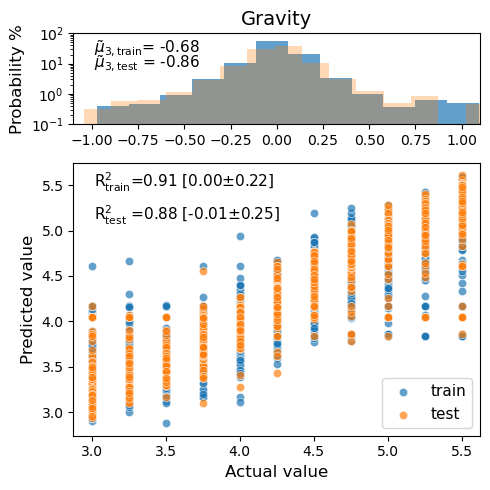



----------------------- Test ------------------------
R2: 0.90 	  RMSE: 0.22 	 Mean+/-STD: -0.00+/-0.23

----------------------- Train ------------------------
R2: 0.91 	  RMSE: 0.23 	 Mean+/-STD: -0.00+/-0.22


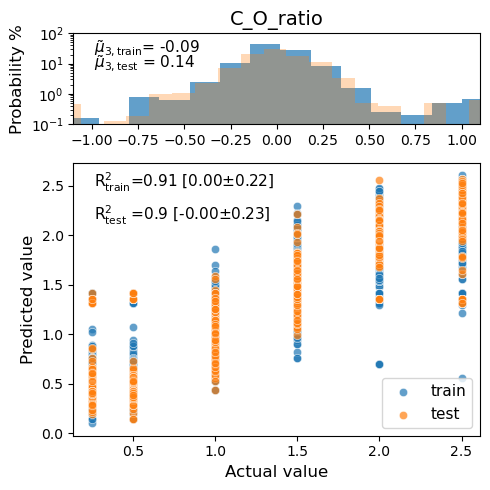



----------------------- Test ------------------------
R2: 0.84 	  RMSE: 0.31 	 Mean+/-STD: 0.00+/-0.35

----------------------- Train ------------------------
R2: 0.87 	  RMSE: 0.35 	 Mean+/-STD: -0.01+/-0.31


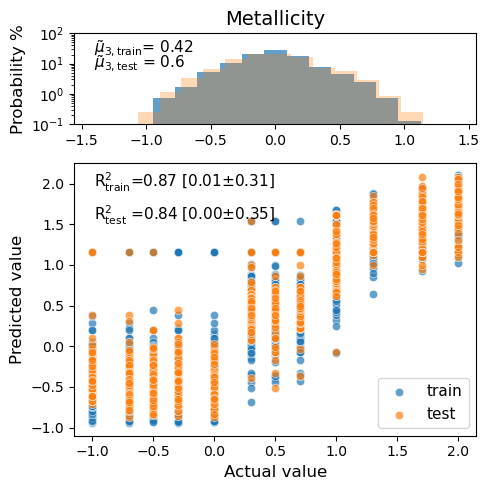



----------------------- Test ------------------------
R2: 1.00 	  RMSE: 22.58 	 Mean+/-STD: -0.96+/-28.26

----------------------- Train ------------------------
R2: 1.00 	  RMSE: 28.28 	 Mean+/-STD: -1.58+/-22.53


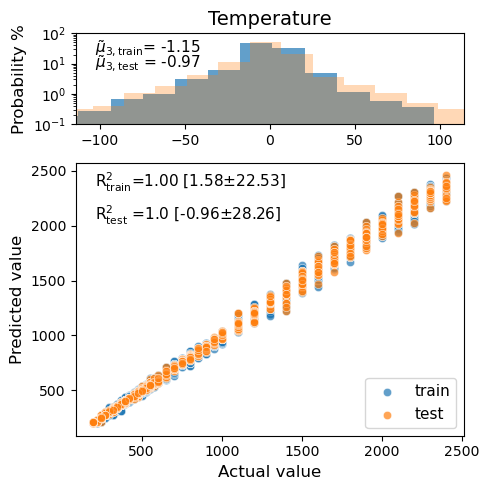

In [43]:
portion_index = 2

regression_report(
        trained_model = xgb_model,
        Xtrain = xgb_model.X_train_standardized_columnwise[::portion_index],
    
        Xtest  = xgb_model.X_test_standardized_columnwise[::portion_index],
    
        ytrain = xgb_model.y_train_standardized_columnwise[::portion_index],
        ytest  = xgb_model.y_test_standardized_columnwise[::portion_index],
        target_i = 4,
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

## Print/Plot Train ML results

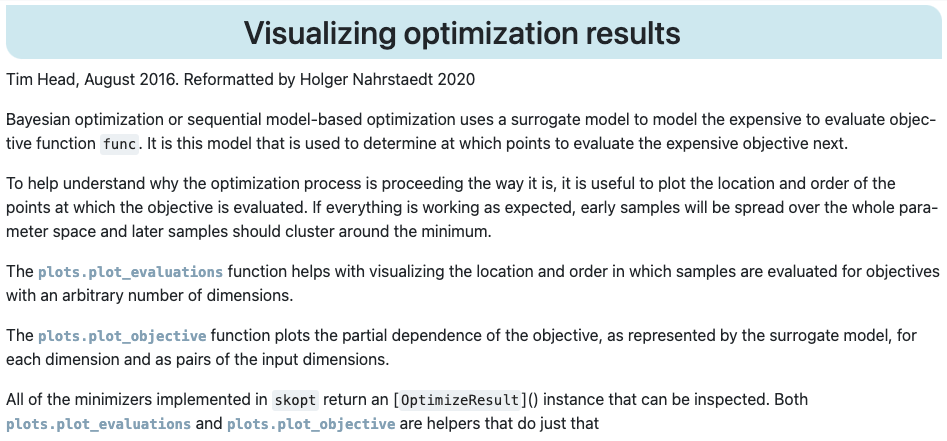

Link: https://scikit-optimize.github.io/stable/auto_examples/plots/visualizing-results.html#sphx-glr-auto-examples-plots-visualizing-results-py

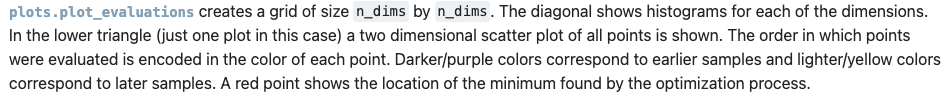

 ==============    Optimal HyperParameters    ============== 
total_iterations 1400
val. score: 0.9438188251461288
test score: 0.9488454084381421
best params: OrderedDict([('colsample_bytree', 0.6), ('learning_rate', 0.015504294682397298), ('max_depth', 8), ('min_child_weight', 1.1), ('n_estimators', 1823), ('reg_lambda', 0.28242200127765676), ('subsample', 1.0)])


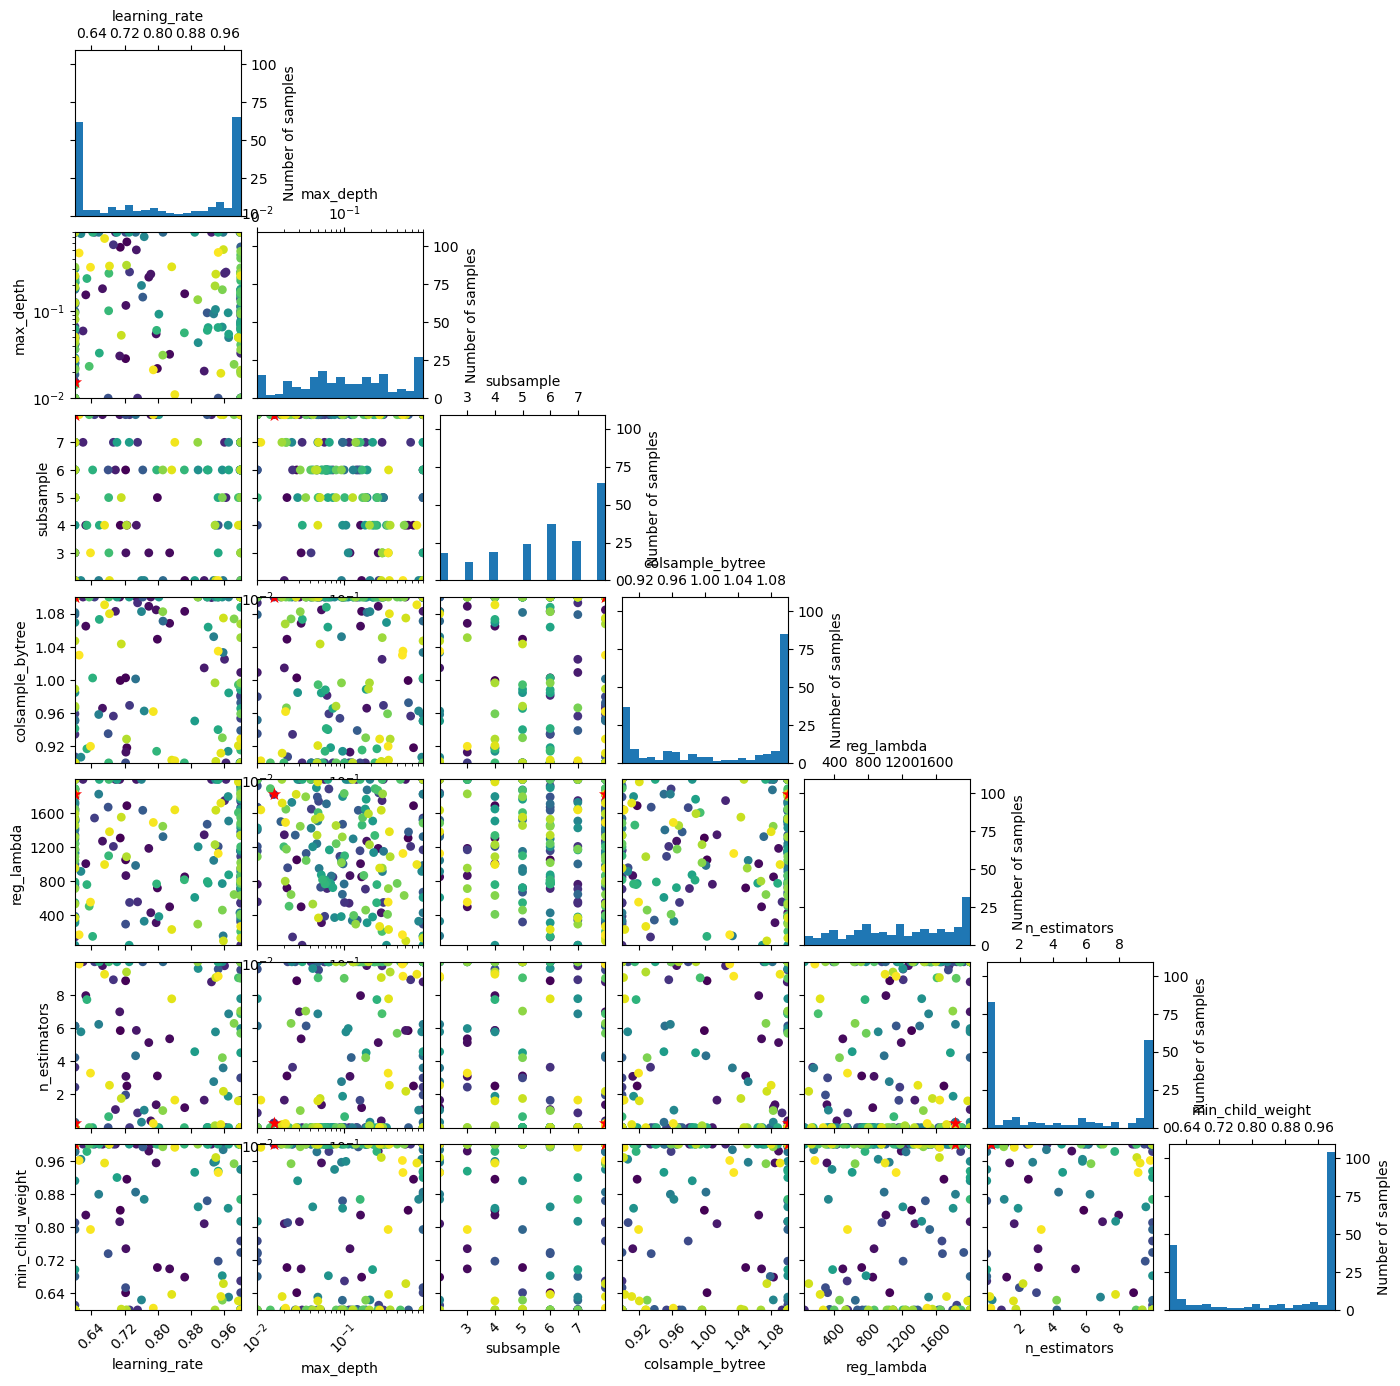

In [8]:
check_model.check_BayesSearchCV(print_results=True,
                                plot_results=True,
                                print_cv_results_df=False,)

## Feature Importnace

feature number -- feature_importnace -- feature_importnace%
  feature_names  feature_importnace
0         1.198            0.001270
1         1.325            0.001369
2         2.438            0.001628
3         2.206            0.002100
4         2.162            0.002108
5         1.379            0.002126
6         2.184            0.002273
7         2.413            0.002300
8         1.788            0.002310
9         1.392            0.002345


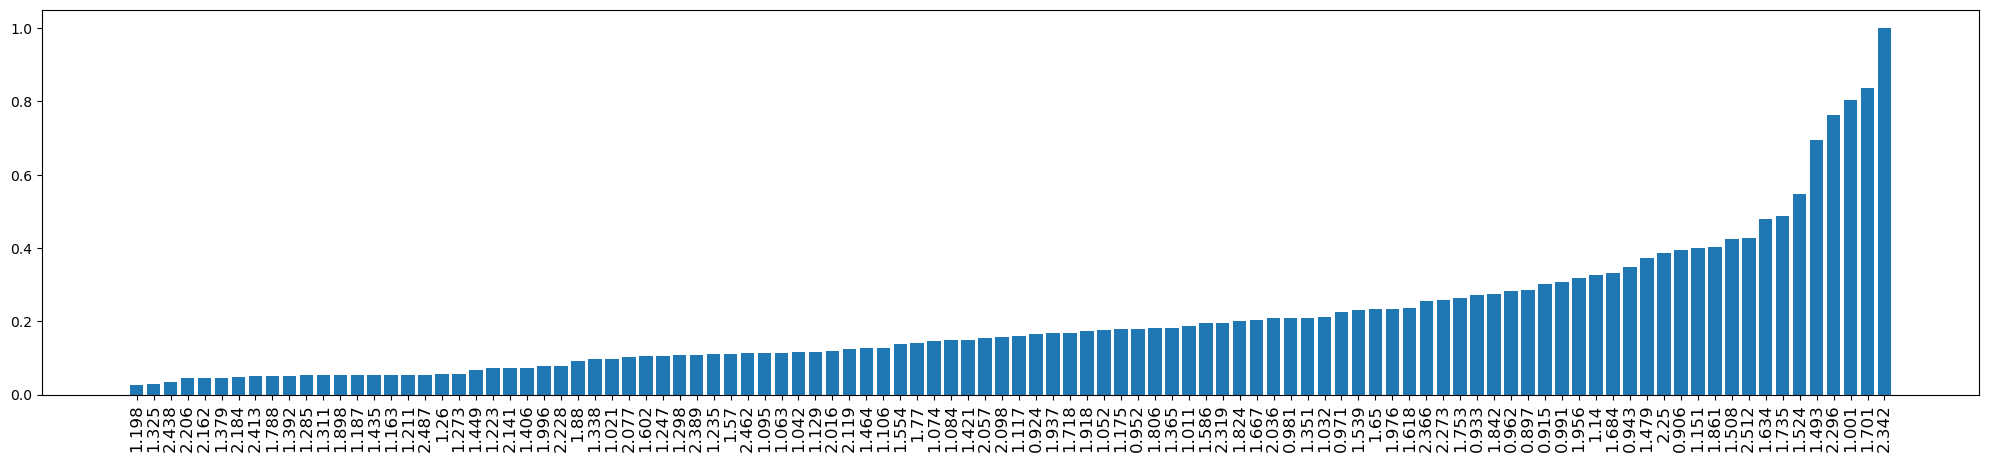

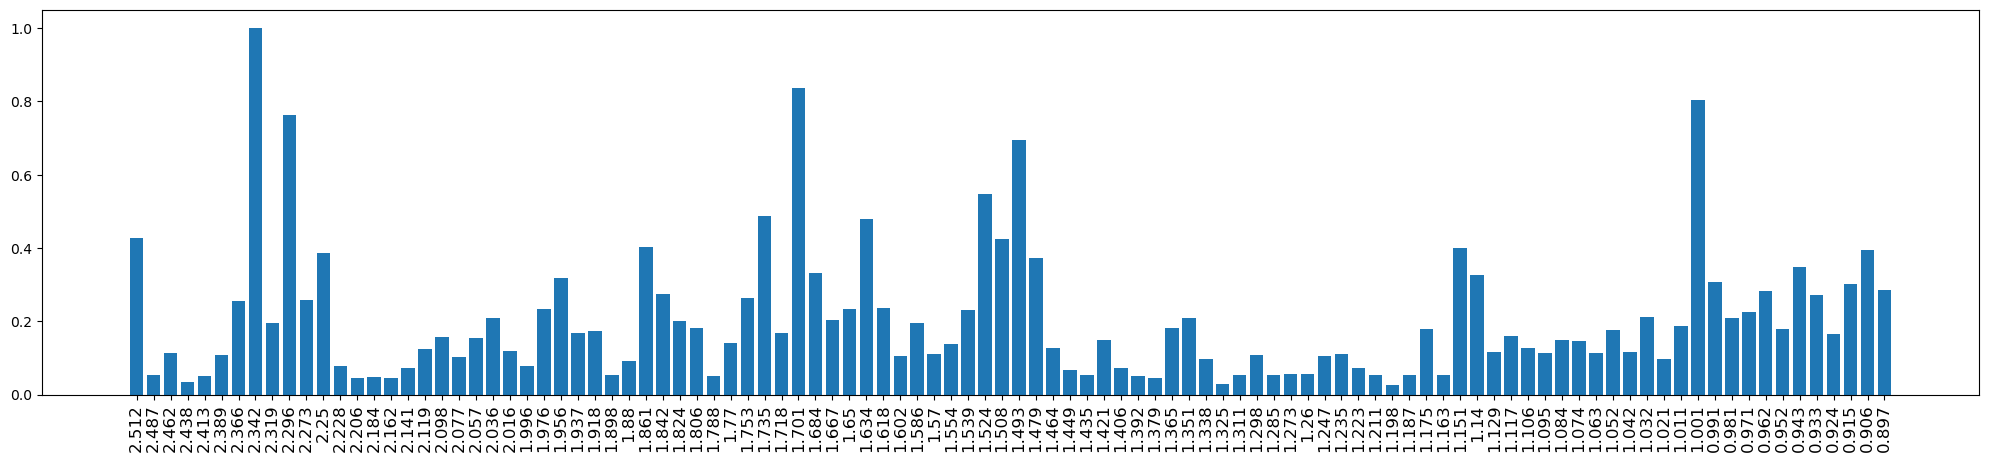

In [9]:
check_model.check_feature_selection_RFE(trained_model = check_model.trained_model,
                                       is_tuned='yes')

# Step 4: Predict Observational data using the trained model

### Load the observational dataset for `Ross 458C`

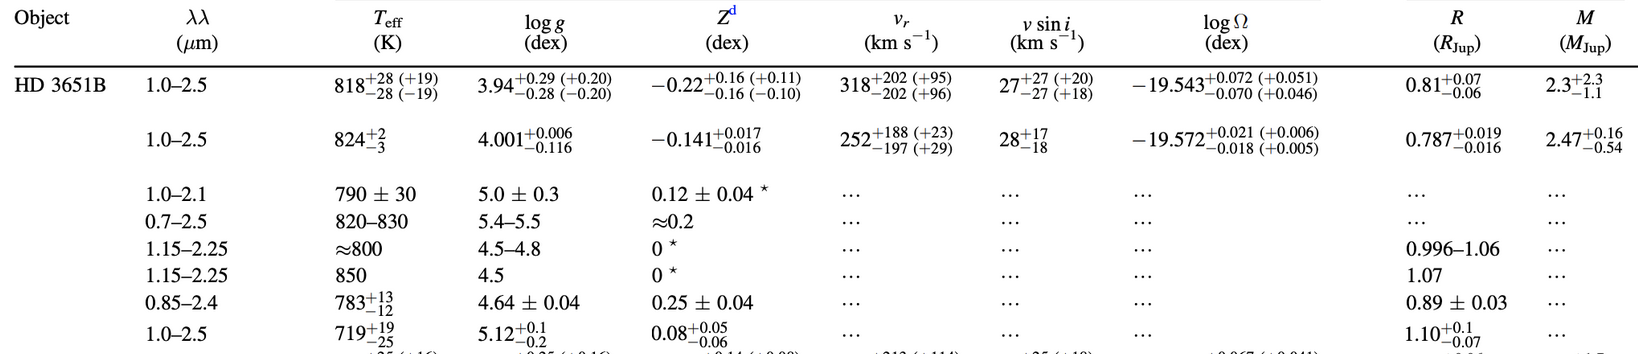

In [36]:
fluxcal = pd.read_csv(f'../../datasets/observational_spectra/HD3651B_fluxcal.dat', 
                   delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                   usecols=(0,1,2))#.dropna(inplace=True)

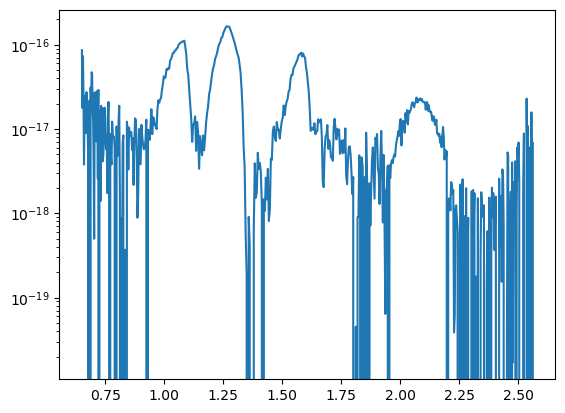

In [37]:
plt.semilogy( fluxcal['wl'],fluxcal['F_lambda']);

In [38]:
fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
fluxcal['F_lambda'].interpolate(inplace=True)

In [39]:
bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                 feature_names_obs  = fluxcal['wl'].values, 
                                 feature_names_synthetic = wl['wl'].values,
                                )

object_name = 'HD3651B'
# add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
if object_name == 'Ross458C':
    bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
if object_name == 'HD3651B':
    bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
if object_name == 'GJ570D':
    bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




bd_object.flux_interpolated(print_results=False, 
                            plot_results=True,
                            use_spectres=True
                           )
bd_object.df_flux_object     


,0.897,0.906,0.915,0.924,0.933,0.943,0.952,0.962,0.971,0.981,...,2.296,2.319,2.342,2.366,2.389,2.413,2.438,2.462,2.487,2.512
0,5.997174e-09,8.576299e-09,6.022747e-09,1.077888e-08,9.085077e-09,1.302502e-08,1.262613e-08,1.206215e-08,1.860160e-08,2.463705e-08,...,7.905764e-09,6.980955e-09,6.795411e-09,4.822663e-09,7.304593e-09,1.166870e-08,8.334444e-09,1.709369e-08,1.834442e-08,2.162885e-08


In [40]:
xxx = xgb_model.standardize_X_ColumnWise.transform( bd_object.df_flux_object.values )

y_pred_train = np.array(xgb_model.trained_model.predict(xxx) )
y_pred_train_ = xgb_model.standardize_y_ColumnWise.inverse_transform( y_pred_train )
y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
y_pred = y_pred_train_

print(y_pred)

[[2.7899399e+00 1.4499029e+00 5.9766090e-01 8.7154291e+02]]


In [41]:
import pandas as pd
import numpy as np
nearest_value_list = []

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value
            nearest_value_list.append(nearest_value)

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return nearest_value_list, filtered_df

# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , 
#                      [4.2024946e+00, 1.2887506e+00, 4.7623226e-01, 809.] ))
# Print the filtered DataFrame

# Filter the DataFrame and get the result
nearest_value1, filtered_df1 = filter_dataframe(df, targets)
display(filtered_df1)


#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================

# Create the figure
p = figure(title='[XStand, yStand] Predicted: '+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(y_pred[0][i],2)) for i in  range(4)]), 
           x_axis_label='X', 
           y_axis_label='Y',
           width=1000, height=300,
           y_axis_type = 'log')

# Add the scatter plot
p.line(x =wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0], 
       line_width = 1,
       legend_label='Modeled:'+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(nearest_value1[i],2)) for i in  range(4)]))
p.circle(x = wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0],
       line_width = 2,
       # legend_label='Observation'
        )



p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
       line_color = 'orange', line_width = 2,
       legend_label='Observation')

# Increase size of x and y ticks
p.title.text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'
p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'

        
p.legend.location = "bottom_right"
p.legend.background_fill_color = 'white'
p.legend.background_fill_alpha = 0.5
        
        # Add the error bars using vbar
# p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

# Show the plot
show(p)

3.0
1.5
0.5
850


,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
12354,3.0,850,1.5,0.5,3.127901e-09,2.639063e-09,1.590345e-09,9.374860e-10,7.714199e-10,4.265212e-10,...,3.406987e-09,2.389369e-09,2.421939e-09,2.243101e-09,1.370576e-09,2.330817e-09,1.511027e-09,7.513302e-10,3.179793e-10,no


---

In [27]:
import random
from bokeh.palettes import magma

spectra_list = []
param_list = []
    
def PredictObsParametersRegression2(object_name, 
                                    predict_from_random_spectra = True,
                                    random_spectra_num=100,
                                    print_results = True,
                                    plot_results = True,
                                    print_df_describe = True,
                                    plot_histogram = True
                                   ):

    color = magma(100).__iter__()
   
    
    if predict_from_random_spectra:
        fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                           delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                           usecols=(0,1,2))#.dropna(inplace=True)


        for i in range(random_spectra_num):



            # Process the dataset
            fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
            fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
            fluxcal['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )

        # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            spectra = pd.DataFrame( [random.uniform(fluxcal.F_lambda[i]-2*fluxcal.F_lambda_error[i], 
                                 fluxcal.F_lambda[i]+2*fluxcal.F_lambda_error[i]) 
                                 for i in range(len(fluxcal))],columns=['F_lambda'] )



            # Process the dataset
            spectra['F_lambda'] = spectra['F_lambda'].mask(spectra['F_lambda'].lt(0),0)
            spectra['F_lambda'].replace(0, np.nan, inplace=True)
            spectra['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = spectra['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )


            # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            if object_name == 'Ross458C':
                bd_object_generated.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
            if object_name == 'HD3651B':
                bd_object_generated.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
            if object_name == 'GJ570D':
                bd_object_generated.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    


            bd_object_generated.flux_interpolated(print_results=False, 
                                        plot_results=False,
                                        use_spectres=True
                                       )
            bd_object_generated.df_flux_object   

            spectra_list.append(bd_object_generated.df_flux_object.values)

            xxx = xgb_model.standardize_X_ColumnWise.transform( bd_object_generated.df_flux_object.values )

            y_pred_train = np.array(xgb_model.trained_model.predict(xxx) )
            y_pred_train_ = xgb_model.standardize_y_ColumnWise.inverse_transform( y_pred_train )
            y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
            y_pred = y_pred_train_

            print (y_pred[0])
            param_list.append(  y_pred[0] )
            
            df_random_pred = pd.DataFrame( param_list, columns=['logg' ,'c_o' ,'met' ,'T'])


        if print_results:
            print(param_list)

        if plot_results:
            
            p = figure(title="Randomly generated spectra in 2σ", 
                       x_axis_label='features [wavelengths]', y_axis_label='Flux (Fν)',
                       width=800, height=300,
                       y_axis_type="log", background_fill_color="#fafafa"
                      )
            
            
            for i in range(0,random_spectra_num,1):
                    p.line(wl.wl.values,spectra_list[i][0], 
                           line_width = 1,
                           line_alpha = 0.6, 
                           line_color=next(color),
                           )
            show(p)

            
        if print_df_describe:
            print(df_random_pred.describe())
            
           
        if plot_histogram:
            plt.figure()
            df_random_pred.hist()
            plt.show()
            
        return df_random_pred

    elif predict_from_random_spectra == False:
        
        
        
        fluxcal2 = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                           delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                           usecols=(0,1,2))#.dropna(inplace=True)

       # Process the dataset
        fluxcal2['F_lambda']=fluxcal2['F_lambda'].mask(fluxcal2['F_lambda'].lt(0),0)
        fluxcal2['F_lambda'].replace(0, np.nan, inplace=True)
        fluxcal2['F_lambda'].interpolate(inplace=True)

        bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal2['F_lambda'].values,
                                         feature_names_obs  = fluxcal2['wl'].values, 
                                         feature_names_synthetic = wl['wl'].values,
                                        )

        object_name = 'HD3651B'
        # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
        if object_name == 'Ross458C':
            bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
        if object_name == 'HD3651B':
            bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
        if object_name == 'GJ570D':
            bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




        bd_object.flux_interpolated(print_results=False, 
                                    plot_results=True,
                                    use_spectres=True
                                   )
        bd_object.df_flux_object     




        xxx = xgb_model.standardize_X_ColumnWise.transform( bd_object.df_flux_object.values )

        y_pred_train = np.array(xgb_model.trained_model.predict(xxx) )
        y_pred_train_ = xgb_model.standardize_y_ColumnWise.inverse_transform( y_pred_train )
        y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
        y_pred = y_pred_train_

        print (y_pred[0])



[2.9724996e+00 1.3270241e+00 8.4903389e-02 8.4208960e+02]
[2.8726668e+00 1.2143753e+00 1.7653283e-01 8.6131793e+02]
[2.8908942e+00 1.2433732e+00 1.6631131e-01 8.4793976e+02]
[ 2.4543996e+00  1.1501187e+00 -2.5247188e-02  8.4078650e+02]
[2.9558411e+00 1.3834044e+00 6.5481752e-02 8.3900714e+02]
[2.7989550e+00 1.4386348e+00 2.3546124e-01 8.5283740e+02]
[2.9202013e+00 1.5103680e+00 2.5210333e-01 8.6802002e+02]
[2.8755379e+00 1.4230815e+00 2.1956538e-01 8.4876642e+02]
[ 2.6773026e+00  1.2118438e+00 -3.6819667e-02  8.4984113e+02]
[3.0495825e+00 1.5216527e+00 7.8934759e-02 8.6292572e+02]
[2.8794086e+00 1.2088765e+00 2.0884977e-01 8.6033405e+02]
[2.9310336e+00 1.3992851e+00 2.5275642e-01 8.8985913e+02]
[2.8979423e+00 1.4641060e+00 9.8648250e-02 8.6017017e+02]
[2.8929794e+00 1.3267670e+00 2.0830904e-01 8.5800452e+02]
[2.7631819e+00 1.2983835e+00 1.3616455e-01 8.4243036e+02]
[ 2.6557708e+00  1.3115844e+00 -7.5175185e-03  8.4824237e+02]
[2.5915098e+00 1.3571855e+00 2.0525078e-01 8.5306592e+02]
[ 

             logg         c_o         met           T
count  100.000000  100.000000  100.000000  100.000000
mean     2.861185    1.362789    0.094631  855.862671
std      0.112901    0.093788    0.101974   10.662302
min      2.454400    1.150119   -0.133588  832.344055
25%      2.775617    1.291487    0.019528  850.030457
50%      2.875162    1.376241    0.083600  854.248993
75%      2.954193    1.437962    0.160874  859.901047
max      3.096291    1.641526    0.394882  889.859131


<Figure size 640x480 with 0 Axes>

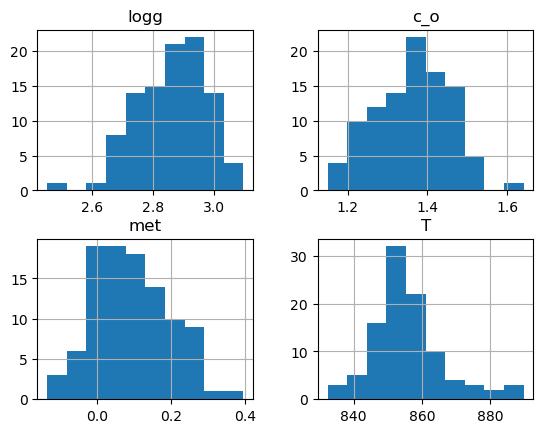

In [29]:
df_random_pred = PredictObsParametersRegression2(object_name = 'HD3651B', 
                                predict_from_random_spectra=True,
                                random_spectra_num=100, 
                                print_results = False,
                                plot_results = True,
                                )

In [30]:
def boxplot_hist(data, x_label, xy_loc):
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.histplot(data, ax=ax_hist, kde=True, stat='probability')
    sns.boxplot(x = data, ax=ax_box, showmeans=True, meanline = True,
                meanprops={"marker": "|",
                           "markeredgecolor": "white",
                           "markersize": "30", 
                            }
                       )
    
    fig.set_figheight(3)
    fig.set_figwidth(3)

    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_yticks([])

    mean = np.round(np.mean(data),1)
    std = np.round(np.std(data),1)
    plt.annotate(f'{x_label}='+str(np.round(mean,2))+'$\pm$'+str(np.round(std,2)), fontsize=11, 
                 xy=(xy_loc[0], xy_loc[1]), xycoords='axes fraction')
                    
    plt.xlabel(x_label, fontsize = 12)

    plt.show()

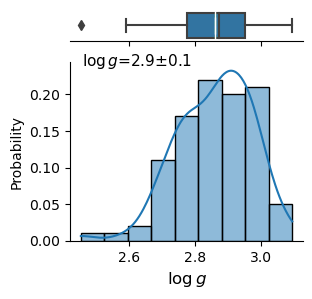

In [31]:
boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)

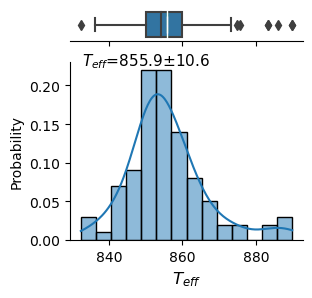

In [32]:
boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)

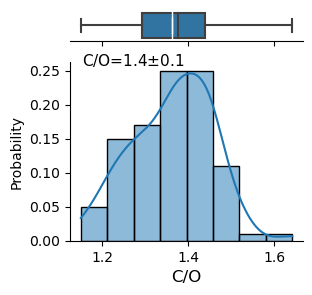

In [33]:
boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)

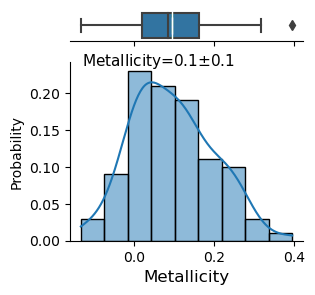

In [34]:
boxplot_hist(df_random_pred['met'], x_label=r'Metallicity', xy_loc=[0.05,0.98],)

---
### __Save the results__ 

In [14]:
ml1.save_model_metrics_fram_checkingStep()

#  * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 